# Computational Finance 630 GWP Submission 1

### Solutions for questions 4, 5, 6, 7

Import all the required libraries for calculations

In [47]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from math import log, sqrt, exp
import random
import scipy as sp

### 4. Price a European call option with the information provided. (2 pts)

Input details

In [51]:
# Input details
risk_free = 0.08 # Risk free rate
S_0 = 100 # today's stock price
sigma = 0.3 # volatility

strike = 100 # Strike price
T = 1 # Maturity in Years
current_time = 0

In [5]:
# Price a plain vanilla european call option using analytical formula
def d1(S_0,strike,T,risk_free,sigma, current_time):
    return(log(S_0/strike)+(risk_free+sigma**2/2.)*(T - current_time))/(sigma*sqrt(T-current_time))

def d2(S_0,strike,T,risk_free,sigma, current_time):
    return d1(S_0,strike,T,risk_free,sigma, current_time)-sigma*sqrt(T-current_time)


def analytic_callprice(S_0,strike,T,risk_free,sigma, current_time):
    return S_0*norm.cdf(d1(S_0,strike,T,risk_free,sigma, current_time))-strike*exp(-risk_free*(T-current_time))*norm.cdf(d2(S_0,strike,T,risk_free,sigma, current_time))

In [10]:
anal_callprice = analytic_callprice(S_0,strike,T,risk_free,sigma, current_time)

In [16]:
anal_callprice

15.711312547892973

15.679781775786577


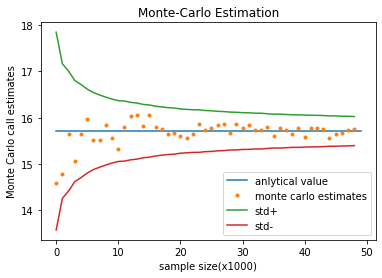

In [55]:
# Price the european call option using Monte Carlo simulations

import warnings
warnings.filterwarnings('ignore')

def determine_terminal_vaue(S_0, risk_free_rate, sigma, Z, T):
    return S_0*np.exp((risk_free_rate-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

def discounted_call_payoff(S_T, K, risk_free_rate, T):
    return np.exp(-risk_free_rate*T)*np.maximum(S_T-K,0)

np.random.seed(0)

mcall_estimates = [None]*50
mcall_std = [None]*50
for i in range(0,50):
    norm_arr = norm.rvs(size = 1000*i)
    term_val = determine_terminal_vaue(S_0,risk_free,sigma,norm_arr,T-current_time)
    mcall_val = discounted_call_payoff(term_val,strike,risk_free,T-current_time)
    mcall_estimates[i-1] = np.mean(mcall_val)
    mcall_std[i-1] = np.std(mcall_val)/np.sqrt(i*1000)

print(np.mean(mcall_estimates[0:-1]))    
plt.plot([anal_callprice]*50, label="anlytical value")
plt.plot(mcall_estimates, '.', label="monte carlo estimates")
plt.plot(anal_callprice + np.array(mcall_std)*3, label="std+")
plt.plot(anal_callprice - np.array(mcall_std)*3, label="std-")
plt.legend(loc="lower right")
plt.xlabel("sample size(x1000)")
plt.ylabel("Monte Carlo call estimates")
plt.title("Monte-Carlo Estimation")
plt.show()

### 5. Price a European up-and-out barrier call option: Simulate paths for the underlying share and for the counterparty’s firm value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option. (10 pts)

In [ ]:
n_steps = 12 # 12 months

dt = T/n_steps # dt = 1/12



In [33]:
#Parameters:
risk_free = 0.08
S_0 = 100 #current share price
sigma = 0.3 #Volatility

K = 100
B = 150   #up-and-out barrier
T = 1 #Maturity


sigma_firm = 0.25 #Firm value volatility
debt = 175       #Debt of the firm
recovery_rate = 0.25
corr = 0.2    #Correlation between the counterparty and the stock price
dt = 1/12 #monthly simulations

In [38]:
# Correlation matrix and decompositon
corr_matrix = np.array([[1, corr], [corr, 1]])
L = np.linalg.cholesky(corr_matrix)

np.random.seed(0)

#Terminal share function.
def terminal_value(S_0, risk_free,sigma,Z,T):
    return S_0*np.exp((risk_free-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

def share_path(S_0, risk_free, sigma, Z, dT):
    return S_0 * np.exp(np.cumsum((risk_free - sigma**2/2)*dT + sigma*np.sqrt(dT)*Z, axis=0))

def upout_call_payoff(path, K, risk_free, T):
    if path.any() > B:
        return 0
    else:
        return np.maximum(path[-1] - K,0)


def price_simulation(S_0, risk_free, sigma, dt, K, L):
    for i in range(1, 51):
        mc_upout_price = [None]*50
        norm_martix = norm.rvs(size=[12, 2, i*1000])
        corr_norm_martix = np.array([np.matmul(L, x) for x in norm_martix]) 
        mc_price_path = np.array([share_path(S_0, risk_free, sigma, Z_share, dt) for Z_share in corr_norm_martix[:,0,:].T])
        mc_upout_payoff = np.array([upout_call_payoff(path, K, risk_free, T) for path in mc_price_path])

    return mc_price_path, np.mean(mc_upout_payoff)

In [43]:
mc_price_path, up_and_out_price = price_simulation(S_0, risk_free, sigma, dt, K, L)

In [44]:
mc_price_path

array([[111.69786144, 109.1306342 , 120.13537152, ..., 141.99876636,
        142.40066589, 165.6754127 ],
       [114.42057534, 118.21147011, 124.89199892, ..., 130.01788198,
        123.73532548, 117.08841321],
       [ 98.50391925,  97.00149854, 108.31141058, ..., 103.53538002,
        100.95578262,  90.13152275],
       ...,
       [ 94.92274364, 102.9047451 , 103.41711169, ...,  90.9983252 ,
        100.2806259 ,  98.72090236],
       [104.07716742, 115.53668001, 119.8944222 , ..., 108.45097343,
        108.31653119, 117.89682403],
       [106.84973596,  95.5754178 ,  97.33345919, ...,  63.74347778,
         69.01508315,  79.62525693]])

In [45]:
15.711312547892973 up_and_out_price

16.96572363403599

### 6. Price a European up-and-in barrier call option. Hint: Use the 2 other option prices. (2 pts)

$𝐶𝑎𝑙𝑙_{𝑢𝑝−𝑎𝑛𝑑−𝑜𝑢𝑡} + 𝐶𝑎𝑙𝑙_{𝑢𝑝−𝑎𝑛𝑑−𝑖𝑛} = 𝐶𝑎𝑙𝑙$

$𝐶𝑎𝑙𝑙_{𝑢𝑝−𝑎𝑛𝑑−𝑖𝑛} = 𝐶𝑎𝑙𝑙 - 𝐶𝑎𝑙𝑙_{𝑢𝑝−𝑎𝑛𝑑−𝑜𝑢𝑡}$

In [56]:
15.711312547892973-16.96572363403599

-1.2544110861430156

### 7. Repeat Question 5 (Price up-and-out barrier call) 6 times, keeping all the data the same, but using a new strike level in each case: a) 85, b) 90, c) 95, d) 105, e) 110, f) 115. Produce a table of 7 rows that shows the strike, and the option price. (2 pts)

In [57]:
# Stike prices = 85, 90, 95, 105, 110, 115
for K in [85, 90, 95, 105, 110, 115]:
    mc_price_path, up_and_out_price = price_simulation(S_0, risk_free, sigma, dt, K, L)
    print("-------For Strike price = ", K, "--------")
    print("Share Price paths")
    print(mc_price_path)
    print("up and out price")
    print(up_and_out_price)

-------For Strike price =  85 --------
Share Price paths
[[ 99.6495607  107.57632036 109.07283535 ... 115.83102153 102.62112183
   90.18989912]
 [ 95.26540748  83.95006702 104.32736681 ...  84.37541601  84.06623269
   98.98874642]
 [ 98.35738847  93.66869677 103.87118396 ...  93.93198278  90.39859613
   98.15962476]
 ...
 [116.57122816 102.97117386  96.20318491 ...  86.97769697  79.7199239
   77.68367423]
 [100.55386817  94.31348151  96.33233516 ...  92.65248333  93.02478489
   90.35783792]
 [ 99.24271443  93.32194131  89.33199254 ...  47.9316207   47.83318159
   46.4321691 ]]
up and out price
26.61950234840665
-------For Strike price =  90 --------
Share Price paths
[[ 98.73308733  96.47093193  96.8802617  ... 114.31665065 109.03934367
  112.28978911]
 [ 97.94738222  92.75733514  94.30686782 ...  79.09271286  73.46470417
   77.77946613]
 [ 82.11008125  86.00294266  91.29098027 ...  70.39878875  59.988338
   60.80072913]
 ...
 [101.0603282   93.15080155  86.31174636 ...  68.15365872  7